In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as font_manager
import time
import datetime
import os
import re
from textwrap import wrap
from util.consts import get_size_bucket_list,get_size_bucket_list_output,LINK_TO_DELAY_DICT,get_base_delay_pmn,color_list,linestyle_list,hatch_list,markertype_list,UNIT_G,UNIT_M,UNIT_K,MTU,DELAY_PROPAGATION_BASE,HEADER_SIZE,BYTE_TO_BIT

BDP_DICT = {
    3: 5 * MTU,
    5: 10 * MTU,
    7: 15 * MTU,
}

def findall(pattern, string):
    while True:
        match = re.search(pattern, string)
        if not match:
            break
        yield match.group(0)
        string = string[match.end():]

def plot_cdf(
    raw_data,
    file_name,
    linelabels,
    x_label,
    y_label="CDF",
    log_switch=False,
    rotate_xaxis=False,
    ylim_low=0,
    xlim=None,
    xlim_bottom=None,
    fontsize=15,
    legend_font=15,
    loc=2,
    title=None,
    enable_abs=False,
    group_size=1,
):
    _fontsize = fontsize
    fig = plt.figure(figsize=(6, 4))  # 2.5 inch for 1/3 double column width
    ax = fig.add_subplot(111)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    if log_switch:
        ax.set_xscale("log")

    plt.ylabel(y_label, fontsize=_fontsize)
    plt.xlabel(x_label, fontsize=_fontsize)
    linelabels = ["\n".join(wrap(l, 30)) for l in linelabels]
    for i in range(len(raw_data)):
        data = raw_data[i]
        data = data[~np.isnan(data)]
        if len(data) == 0:
            continue
        if enable_abs:
            data = abs(data)
        # data=random.sample(data,min(1e6,len(data)))
        data_size = len(data)
        # data=list(filter(lambda score: 0<=score < std_val, data))
        # Set bins edges
        data_set = sorted(set(data))
        bins = np.append(data_set, data_set[-1] + 1)

        # Use the histogram function to bin the data
        counts, bin_edges = np.histogram(data, bins=bins, density=False)

        counts = counts.astype(float) / data_size

        # Find the cdf
        cdf = np.cumsum(counts)

        # Plot the cdf
        if i < len(linelabels):
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                label=linelabels[i],
                linewidth=3,
            )
        else:
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                linewidth=3,
            )

    legend_properties = {"size": legend_font}
    plt.legend(
        prop=legend_properties,
        frameon=False,
        loc=loc,
    )

    plt.ylim((ylim_low, 1))
    if xlim_bottom:
        plt.xlim(left=xlim_bottom)
    if xlim:
        plt.xlim(right=xlim)
    # plt.tight_layout()
    # plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    # plt.grid(True)
    if rotate_xaxis:
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    if title:
        plt.title(title, fontsize=_fontsize - 5)
    # plt.savefig(file_name, bbox_inches="tight", pad_inches=0)
def decode_dict(d, encoding_used = 'utf-8'):
    return { k.decode(encoding_used) : (v.decode(encoding_used) if isinstance(v, bytes) else v) for k, v in d.items() }

In [2]:
lr =10
labels = {
    0: "(0,MTU]",
    1: "(MTU,BDP]",
    2: "(BDP,5BDP]",
    3: "(5BDP,inf)",
}

60000 0.07424434628790424
180000 0.003931266085015402
360000 0.002126478607088353
40000 0.2059218202221763
60000 0.02086782679564569
80000 0.05120025202334817
60000 0.17442268272601089
200000 0.003508890275362281
420000 0.001101706624683565
40000 0.4736540038925558
80000 0.048569099135143914
120000 0.043775878893902574
40000 0.14801215162910997
80000 0.15873170330434003
120000 0.018359855415194627
60000 0.017568464313239985
140000 0.04138313954707858
280000 0.010418636048773786
60000 0.07469056525645912
180000 0.016482697199171736
340000 0.014329028294040856
40000 0.7999163607380221
80000 0.006766454107186933
160000 0.024354683481888857
40000 0.9013845920280751
80000 0.010031902317918732
120000 0.009738277872918961
40000 0.43861923009336595
120000 0.05519159282783134
220000 0.015586610978084423
60000 0.009681148911062401
140000 0.025189268480630574
260000 0.0018534689070007634
40000 0.2493792254479917
120000 0.08176685598424455
220000 0.007288331894474039
40000 0.2099754645063151
12000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


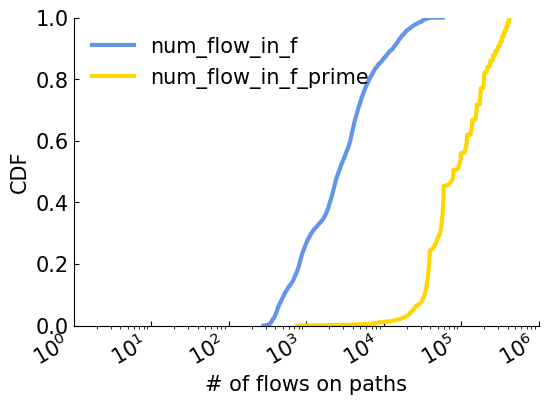

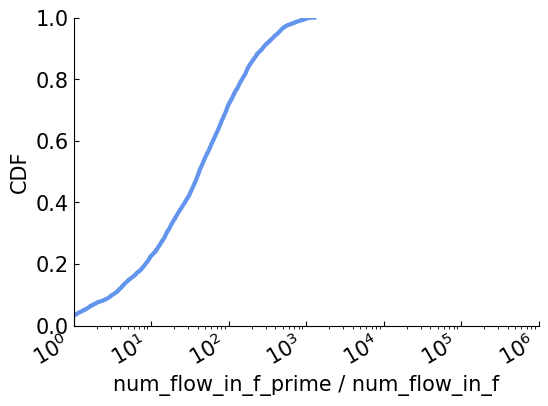

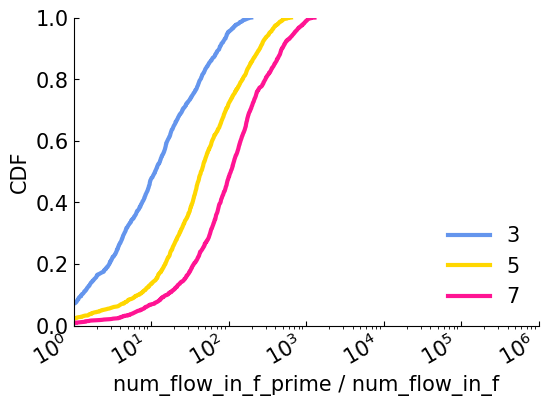

In [6]:
from collections import defaultdict
dir_input_synthetic="/data2/lichenni/path_pmn_tc_0116"
topo_type="_topo-pl-x_dctcp_k30"
enable_longest_foreground_traffic=True
dir_input=dir_input_synthetic

res=[]
res_dict=defaultdict(list)
for shard in np.arange(2000):
    for n_flows in [20000]:
        for n_hosts in [3,5,7]:
            topo_type_cur=topo_type.replace("-x_",f"-{n_hosts}_")
            spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
            dir_input_tmp = f"{dir_input}/{spec}"
            stats=decode_dict(np.load(f'{dir_input_tmp}/stats.npy', allow_pickle=True,encoding="bytes").item())
            n_flows_total=stats["n_flows"]
            num_flow_in_f=int(stats["ratio"]*n_flows_total)
            num_flow_in_f_prime=n_flows_total-num_flow_in_f
            res.append([num_flow_in_f,num_flow_in_f_prime])
            res_dict[n_hosts].append([num_flow_in_f,num_flow_in_f_prime]) 
res_dict={key:np.array(res_dict[key]).transpose() for key in res_dict}  
res=np.array(res).transpose()
print(res.shape)
plot_cdf(res,'xxx.pdf',['num_flow_in_f','num_flow_in_f_prime'],'# of flows on paths',legend_font=15,group_size=len(res),loc=2,rotate_xaxis=True,log_switch=True,xlim=1000001,xlim_bottom=1)
res=(res[1]/res[0])[None,:]
print(res.shape)
plot_cdf(res,'xxx.pdf',[],'num_flow_in_f_prime / num_flow_in_f',legend_font=15,group_size=len(res),loc=4,rotate_xaxis=True,log_switch=True,xlim=1000001,xlim_bottom=1)

plot_cdf([np.array(res_dict[key][1]/res_dict[key][0]) for key in res_dict],'xxx.pdf',[str(key) for key in res_dict],'num_flow_in_f_prime / num_flow_in_f',legend_font=15,group_size=3,loc=4,rotate_xaxis=True,log_switch=True,xlim=1000001,xlim_bottom=1)

In [9]:

# dir_input_synthetic="/data2/lichenni/path/input"
dir_input_synthetic="/data2/lichenni/path_pmn_tc_0107"
topo_type="_topo-pl-x_dctcp"
data_list_seeds = []
enable_longest_foreground_traffic=True
dir_input=dir_input_synthetic

data_list=[]
for shard in np.arange(1):
    for n_flows in [20000]:
        for n_hosts in [3,5,7]:
            # for dctcp_k in [5000,18000,30000]:
            for dctcp_k in [30]:
                topo_type_cur=topo_type.replace("-x_",f"-{n_hosts}_")+f"_k{dctcp_k}"
                spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                dir_input_tmp = f"{dir_input}/{spec}"
                if not os.path.exists(f'{dir_input_tmp}/flow_src_dst.npy'): continue
                flow_src_dst = np.load(f'{dir_input_tmp}/flow_src_dst.npy')
                stats=decode_dict(np.load(f'{dir_input_tmp}/stats.npy', allow_pickle=True,encoding="bytes").item())
                n_flows_total=stats["n_flows"]
                if len(flow_src_dst)==n_flows_total:
                    if enable_longest_foreground_traffic:
                        data_list.append((spec,(0,n_hosts-1),topo_type_cur))
                    else:
                        pair_threshold=n_flows
                        for i in range(n_hosts-1):
                            for j in range(i+1,n_hosts):
                                if np.count_nonzero(np.logical_and(flow_src_dst[:,0]==i, flow_src_dst[:,1]==j))>=pair_threshold:
                                    data_list.append((spec,(i,j),topo_type_cur))

In [10]:
print(len(data_list))
print(data_list)

3
[('shard0_nflows20000_nhosts3_lr10Gbps', (0, 2), '_topo-pl-3_dctcp_k30'), ('shard0_nflows20000_nhosts5_lr10Gbps', (0, 4), '_topo-pl-5_dctcp_k30'), ('shard0_nflows20000_nhosts7_lr10Gbps', (0, 6), '_topo-pl-7_dctcp_k30')]


In [6]:
import numpy as np
def weighted_percentile(data, weights, perc):
    """
    perc : percentile in [0-1]!
    """
    perc=perc/100.0
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)


# Example usage
data = np.array([1, 2, 3, 4, 5])
weights = np.array([0.1, 0.2, 0.3, 0.2, 0.2])
percentile_value = weighted_percentile(data, weights, np.arange(0, 101, 1))

percentile_value = weighted_percentile(data, weights, np.arange(0, 101, 1))

print(f"The 50th percentile (median) with weights is: {percentile_value}")


The 50th percentile (median) with weights is: [1.         1.         1.         1.         1.         1.
 1.06666667 1.13333333 1.2        1.26666667 1.33333333 1.4
 1.46666667 1.53333333 1.6        1.66666667 1.73333333 1.8
 1.86666667 1.93333333 2.         2.04       2.08       2.12
 2.16       2.2        2.24       2.28       2.32       2.36
 2.4        2.44       2.48       2.52       2.56       2.6
 2.64       2.68       2.72       2.76       2.8        2.84
 2.88       2.92       2.96       3.         3.04       3.08
 3.12       3.16       3.2        3.24       3.28       3.32
 3.36       3.4        3.44       3.48       3.52       3.56
 3.6        3.64       3.68       3.72       3.76       3.8
 3.84       3.88       3.92       3.96       4.         4.05
 4.1        4.15       4.2        4.25       4.3        4.35
 4.4        4.45       4.5        4.55       4.6        4.65
 4.7        4.75       4.8        4.85       4.9        4.95
 5.         5.         5.         5.         

spec=shard0_nflows20000_nhosts7_lr10Gbps,_topo-pl-7_dctcp_k30
78.187s
************************************************************************************************************************************************
shard0_nflows20000_nhosts7_lr10Gbps
p99 percentile: 3.70803545970448, 1.191534601668275
p99 percentile: 3.14705925780373, 1.9865075605392843
p99 percentile: 3.511726302961322, 2.8379565189398592
p99 percentile: 3.7977496755578284, 3.1009187572733024


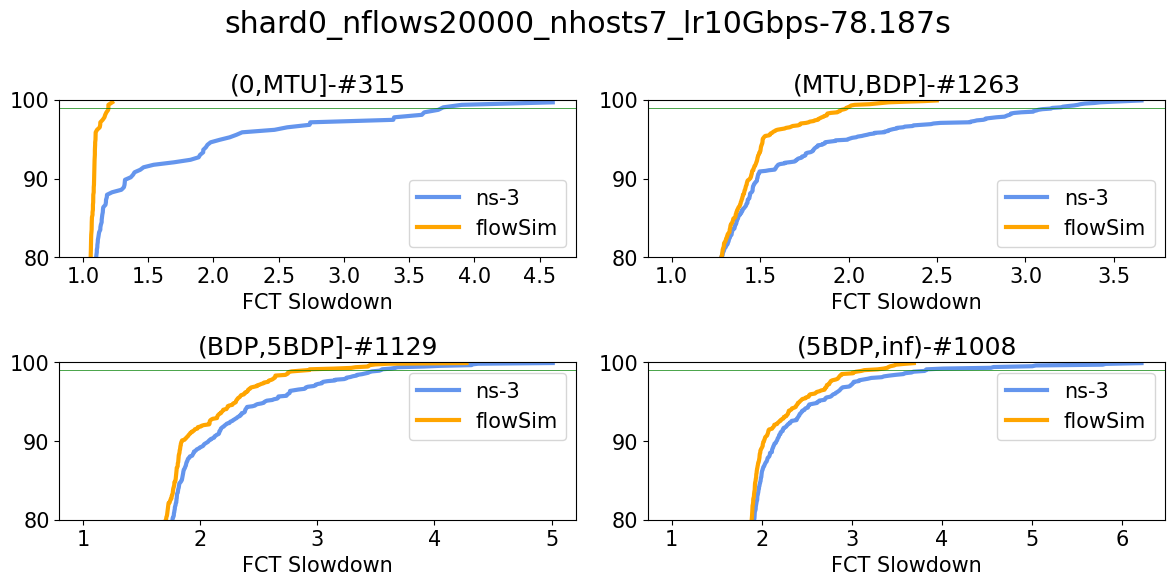

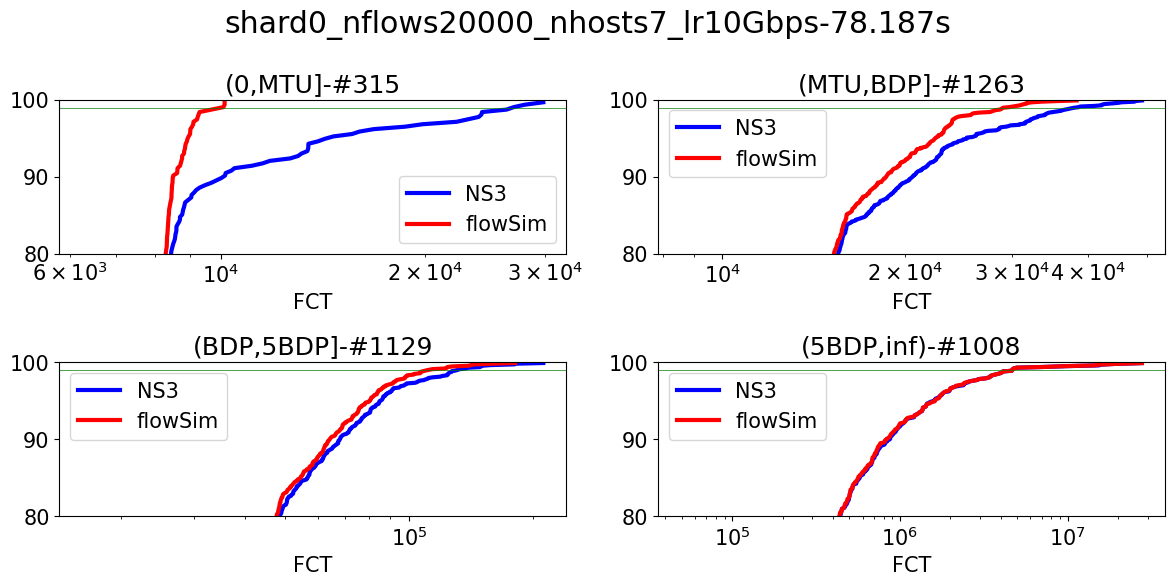

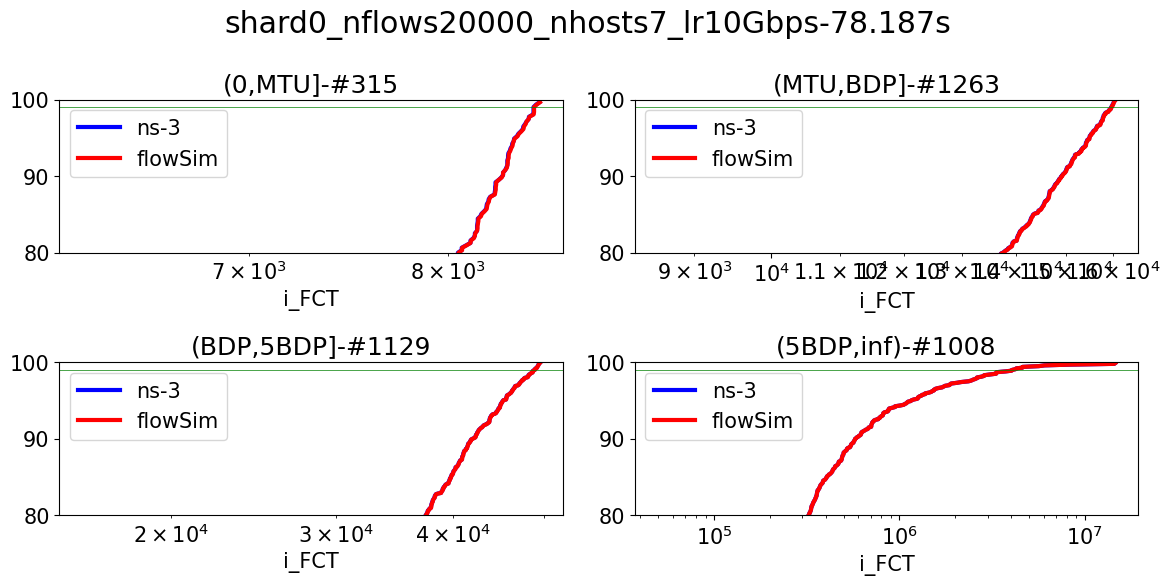

In [13]:
# [FINAL]: NS3 vs MaxMinFair
fig_index=0
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate([data_list[2]]):
    print(f"spec={spec},{topo_type}")
    dir_input_tmp = f"{dir_input}/{spec}"
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    # BDP=BDP_DICT[n_hosts]
    BDP=10*MTU
    
    flow_src_dst=np.load(f'{dir_input_tmp}/flow_src_dst.npy')
    flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
    flow_idx_nontarget=~flow_idx_target
    flow_idx_nontarget_internal=np.logical_and(flow_src_dst[:,0]!=src_dst_pair_target[0], flow_src_dst[:,1]!=src_dst_pair_target[1])
    sizes = np.load(f"{dir_input_tmp}/flow_sizes.npy")
    fats = np.load(f"{dir_input_tmp}/flow_arrival_times.npy")
    fcts = np.load(f'{dir_input_tmp}/fcts{topo_type}.npy')
    i_fcts = np.load(f'{dir_input_tmp}/i_fcts{topo_type}.npy')
    sldns = np.divide(fcts, i_fcts)
    
    deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
    print(f"{deq_time_max}s")

    flow_src_dst=np.load(f'{dir_input}/{spec}/flow_src_dst.npy')
    n_links_passed=abs(flow_src_dst[:,0]-flow_src_dst[:,1])+flow_idx_nontarget+flow_idx_nontarget_internal
    # lr_bottleneck=get_lr_bottleneck(lr,n_hosts,flow_src_dst)
    lr_bottleneck=lr
    
    delay_extra=LINK_TO_DELAY_DICT[n_hosts][flow_src_dst[:,0]]+LINK_TO_DELAY_DICT[n_hosts][flow_src_dst[:,1]]
    base_delay=get_base_delay_pmn(sizes,n_links_passed,lr_bottleneck,flow_idx_target,flow_idx_nontarget_internal)+delay_extra
    i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT / lr_bottleneck + base_delay
    # fcts_flowsim=i_fcts_flowsim
    fcts_flowsim = np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')+ base_delay
    sldns_flowsim = np.divide(fcts_flowsim, i_fcts_flowsim)
    
    # flow_idx_target=~flow_idx_target
    sizes=sizes[flow_idx_target]
    sldns=sldns[flow_idx_target]
    fcts=fcts[flow_idx_target]
    i_fcts=i_fcts[flow_idx_target]
    
    sldns_flowsim=sldns_flowsim[flow_idx_target]
    fcts_flowsim=fcts_flowsim[flow_idx_target]
    i_fcts_flowsim=i_fcts_flowsim[flow_idx_target]
    
    bins = np.digitize(sizes, [MTU, BDP, 5 * BDP])
    
    print("************************************************************************************************************************************************")
    print(f'{spec}')
    plt.figure(fig_index,figsize=(12, 6))
    plt.rcParams.update({'font.size': 15})
    plt.suptitle(f"{spec}-{deq_time_max}s", fontsize="x-large")
    for i in range(len(labels)):
        gt = np.extract(bins==i, sldns)
        estimated_flowsim = np.extract(bins==i, sldns_flowsim)
        print(f"p99 percentile: {np.percentile(gt,99)}, {np.percentile(estimated_flowsim,99)}")
        # sample_list=sorted(np.random.choice(np.arange(len(gt)),np.min([len(gt),100000]),replace=False))
        sample_list=np.arange(len(gt))
        plt.subplot(2, 2, i + 1)
        plt.title(f"{labels[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        plt.plot(np.sort(gt)[sample_list], (np.arange(len(gt))/len(gt)*100)[sample_list], label='ns-3', color=color_list[0], linewidth=3)
        plt.plot(np.sort(estimated_flowsim)[sample_list], (np.arange(len(estimated_flowsim))/len(estimated_flowsim)*100)[sample_list], label='flowSim', color=color_list[1], linewidth=3)

        plt.axhline(99, color='green', linewidth=0.5)
        # plt.xscale('log')
        plt.xlabel('FCT Slowdown')
        plt.legend()
        plt.ylim([80, 100])
    plt.tight_layout()
    fig_index+=1
    plt.figure(fig_index,figsize=(12, 6))
    plt.suptitle(f"{spec}-{deq_time_max}s", fontsize="x-large")
    for i in range(len(labels)):
        gt = np.extract(bins==i, fcts)
        estimated_flowsim = np.extract(bins==i, fcts_flowsim)
        
        # sample_list=sorted(np.random.choice(np.arange(len(gt)),np.min([len(gt),100000]),replace=False))
        sample_list=np.arange(len(gt))
        plt.subplot(2, 2, i + 1)
        plt.title(f"{labels[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        plt.plot(np.sort(gt)[sample_list], (np.arange(len(gt))/len(gt)*100)[sample_list], label='NS3', color='blue', linewidth=3)
        plt.plot(np.sort(estimated_flowsim)[sample_list], (np.arange(len(estimated_flowsim))/len(estimated_flowsim)*100)[sample_list], label='flowSim', color='red', linewidth=3)

        plt.axhline(99, color='green', linewidth=0.5)
        plt.xscale('log')
        plt.xlabel('FCT')
        plt.legend()
        plt.ylim([80, 100])
    plt.tight_layout()
    fig_index+=1
    plt.figure(fig_index,figsize=(12, 6))
    plt.suptitle(f"{spec}-{deq_time_max}s", fontsize="x-large")
    for i in range(len(labels)):
        gt = np.extract(bins==i, i_fcts)
        estimated_flowsim = np.extract(bins==i, i_fcts_flowsim)
        
        # sample_list=sorted(np.random.choice(np.arange(len(gt)),np.min([len(gt),100000]),replace=False))
        sample_list=np.arange(len(gt))
        plt.subplot(2, 2, i + 1)
        plt.title(f"{labels[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        plt.plot(np.sort(gt)[sample_list], (np.arange(len(gt))/len(gt)*100)[sample_list], label='ns-3', color='blue', linewidth=3)
        plt.plot(np.sort(estimated_flowsim)[sample_list], (np.arange(len(estimated_flowsim))/len(estimated_flowsim)*100)[sample_list], label='flowSim', color='red', linewidth=3)

        plt.axhline(99, color='green', linewidth=0.5)
        plt.xscale('log')
        plt.xlabel('i_FCT')
        plt.legend()
        plt.ylim([80, 100])
    plt.tight_layout()
    fig_index+=1
    # exit()
    # break

spec=shard0_nflows20000_nhosts7_lr10Gbps,_topo-pl-7_dctcp_k5000
52.458s
************************************************************************************************************************************************
shard0_nflows20000_nhosts7_lr10Gbps
p99 percentile: 1.5464632868000172
spec=shard0_nflows20000_nhosts7_lr10Gbps,_topo-pl-7_dctcp_k18000
52.458s
************************************************************************************************************************************************
shard0_nflows20000_nhosts7_lr10Gbps
p99 percentile: 4.033956911262799
spec=shard0_nflows20000_nhosts7_lr10Gbps,_topo-pl-7_dctcp_k30000
52.458s
************************************************************************************************************************************************
shard0_nflows20000_nhosts7_lr10Gbps
p99 percentile: 5.092459775719165
spec=shard0_nflows20000_nhosts7_lr10Gbps,_topo-pl-7_dctcp_k5000
52.458s
****************************************************************

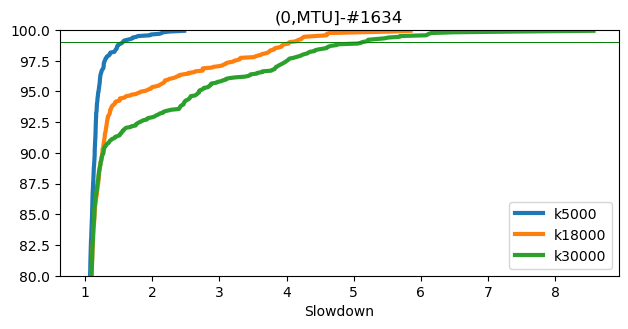

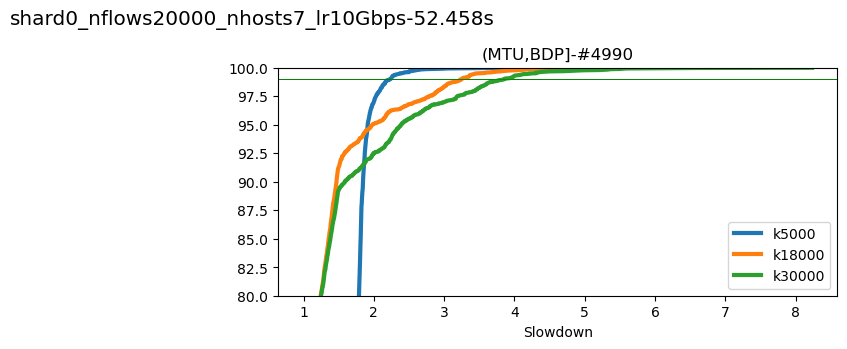

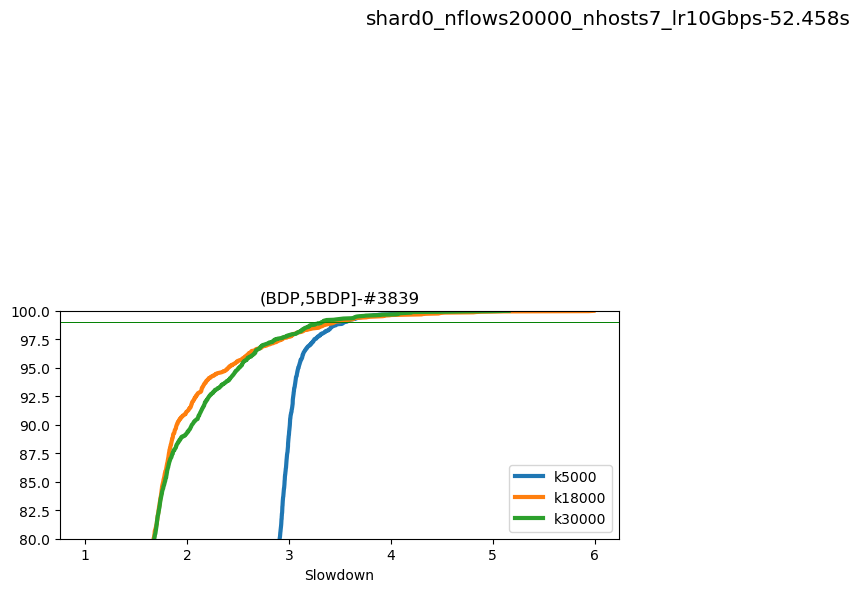

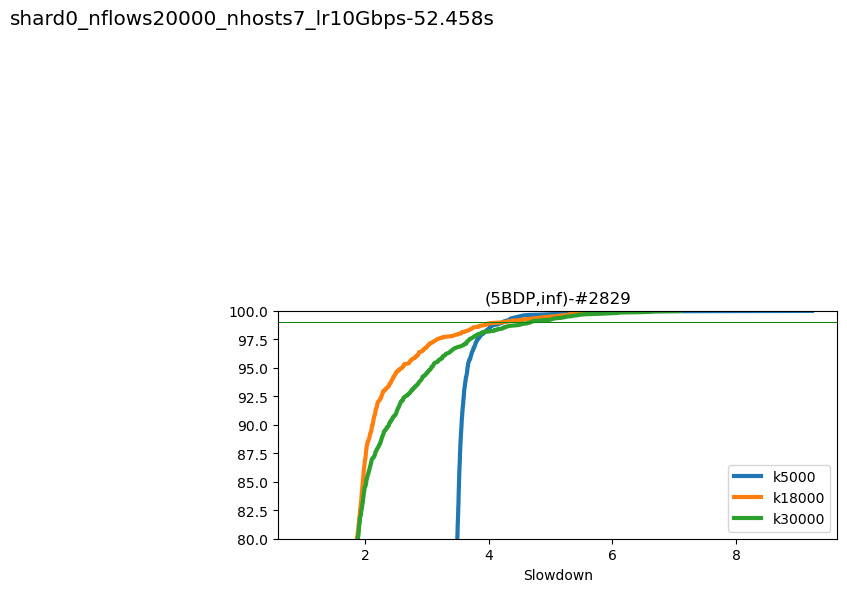

<Figure size 1200x600 with 0 Axes>

In [10]:
# [FINAL]: NS3 vs MaxMinFair
fig_index=0
plt.figure(fig_index,figsize=(12, 6))
for i in range(len(labels)):
    for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
        print(f"spec={spec},{topo_type}")
        dir_input_tmp = f"{dir_input}/{spec}"
        tmp = spec.split("_")
        n_hosts=int(tmp[2][6:])
        # BDP=BDP_DICT[n_hosts]
        BDP=10*MTU
        dctcp_k_str=topo_type.split("_")[-1]
        
        flow_src_dst=np.load(f'{dir_input_tmp}/flow_src_dst.npy')
        flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
        flow_idx_nontarget=~flow_idx_target
        flow_idx_nontarget_internal=np.logical_and(flow_src_dst[:,0]!=src_dst_pair_target[0], flow_src_dst[:,1]!=src_dst_pair_target[1])
        sizes = np.load(f"{dir_input_tmp}/flow_sizes.npy")
        fats = np.load(f"{dir_input_tmp}/flow_arrival_times.npy")
        fcts = np.load(f'{dir_input_tmp}/fcts{topo_type}.npy')
        i_fcts = np.load(f'{dir_input_tmp}/i_fcts{topo_type}.npy')
        sldns = np.divide(fcts, i_fcts)
        
        deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
        print(f"{deq_time_max}s")
        
        # flow_idx_target=~flow_idx_target
        sizes=sizes[flow_idx_target]
        sldns=sldns[flow_idx_target]
        fcts=fcts[flow_idx_target]
        i_fcts=i_fcts[flow_idx_target]
        
        bins = np.digitize(sizes, [MTU, BDP, 5 * BDP])
        
        print("************************************************************************************************************************************************")
        print(f'{spec}')
   
        gt = np.extract(bins==i, sldns)
        print(f"p99 percentile: {np.percentile(gt,99)}")
        # sample_list=sorted(np.random.choice(np.arange(len(gt)),np.min([len(gt),100000]),replace=False))
        sample_list=np.arange(len(gt))
        plt.subplot(2, 2, i + 1)
        plt.title(f"{labels[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        plt.plot(np.sort(gt)[sample_list], (np.arange(len(gt))/len(gt)*100)[sample_list], label=dctcp_k_str, linewidth=3)

        plt.axhline(99, color='green', linewidth=0.5)
        # plt.xscale('log')
        plt.xlabel('Slowdown')
        plt.legend()
        plt.ylim([80, 100])
    plt.tight_layout()
fig_index+=1

In [7]:

# dir_input_synthetic="/data2/lichenni/path/input"
dir_input_synthetic="/data2/lichenni/path_tc"
topo_type="_topo-pl-x_"
data_list_seeds = []
enable_longest_foreground_traffic=True
dir_input=dir_input_synthetic

data_list=[]
# for shard in np.arange(1):
for shard in [0]:
    for n_flows in [20000]:
        for n_hosts in [3]:
            # for dctcp_k in [5000,9000,15000,18000,22000,27000,30000]:
            for k in [18000]:
                for cc in ["dctcp", "timely_vwin","dcqcn_paper_vwin","hp"]:
                # for cc in ["dctcp"]:
                    # for b in [0.5,1.0,2.0]:
                    # for b in [1.0,5.0,50.0]:
                    for b in [1.0]:
                        # for p in [0.1,1.0,2.0]:
                        for p in [1.0]:
                            topo_type_cur=topo_type.replace("-x_",f"-{n_hosts}_")+cc+"_k%d_b%.1f_p%.1f"%(k, b,p)
                            spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                            dir_input_tmp = f"{dir_input}/{spec}"
                            if not os.path.exists(f'{dir_input_tmp}/flow_src_dst.npy'): continue
                            flow_src_dst = np.load(f'{dir_input_tmp}/flow_src_dst.npy')
                            stats=decode_dict(np.load(f'{dir_input_tmp}/stats.npy', allow_pickle=True,encoding="bytes").item())
                            n_flows_total=stats["n_flows"]
                            if len(flow_src_dst)==n_flows_total:
                                if enable_longest_foreground_traffic:
                                    data_list.append((spec,(0,n_hosts-1),topo_type_cur))
                                else:
                                    pair_threshold=n_flows
                                    for i in range(n_hosts-1):
                                        for j in range(i+1,n_hosts):
                                            if np.count_nonzero(np.logical_and(flow_src_dst[:,0]==i, flow_src_dst[:,1]==j))>=pair_threshold:
                                                data_list.append((spec,(i,j),topo_type_cur))

In [8]:
print(data_list)

[('shard0_nflows20000_nhosts3_lr10Gbps', (0, 2), '_topo-pl-3_dctcp_k18000_b1.0_p1.0'), ('shard0_nflows20000_nhosts3_lr10Gbps', (0, 2), '_topo-pl-3_timely_vwin_k18000_b1.0_p1.0'), ('shard0_nflows20000_nhosts3_lr10Gbps', (0, 2), '_topo-pl-3_dcqcn_paper_vwin_k18000_b1.0_p1.0'), ('shard0_nflows20000_nhosts3_lr10Gbps', (0, 2), '_topo-pl-3_hp_k18000_b1.0_p1.0')]


In [2]:
# [FINAL]: NS3 vs MaxMinFair
fig_index=0
plt.figure(fig_index,figsize=(12, 6))
for i in range(len(labels)):
    for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
        print(f"spec={spec},{topo_type}")
        dir_input_tmp = f"{dir_input}/{spec}"
       
        tmp = spec.split("_")
        n_hosts=int(tmp[2][6:])
        # BDP=BDP_DICT[n_hosts]
        BDP=10*MTU
        dctcp_k_str=topo_type[9:]
        
        flow_src_dst=np.load(f'{dir_input_tmp}/flow_src_dst.npy')
        flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
        flow_idx_nontarget=~flow_idx_target
        flow_idx_nontarget_internal=np.logical_and(flow_src_dst[:,0]!=src_dst_pair_target[0], flow_src_dst[:,1]!=src_dst_pair_target[1])
        sizes = np.load(f"{dir_input_tmp}/flow_sizes.npy")
        fats = np.load(f"{dir_input_tmp}/flow_arrival_times.npy")
        fcts = np.load(f'{dir_input_tmp}/fcts{topo_type}.npy')
        i_fcts = np.load(f'{dir_input_tmp}/i_fcts{topo_type}.npy')
        sldns = np.divide(fcts, i_fcts)
        
        deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
        print(f"{deq_time_max}s")
        
        # flow_idx_target=~flow_idx_target
        sizes=sizes[flow_idx_target]
        sldns=sldns[flow_idx_target]
        fcts=fcts[flow_idx_target]
        i_fcts=i_fcts[flow_idx_target]
        
        bins = np.digitize(sizes, [MTU, BDP, 5 * BDP])
        
        print("************************************************************************************************************************************************")
        print(f'{spec}')
   
        gt = np.extract(bins==i, sldns)
        print(f"p99 percentile: {np.percentile(gt,99)}")
        # sample_list=sorted(np.random.choice(np.arange(len(gt)),np.min([len(gt),100000]),replace=False))
        sample_list=np.arange(len(gt))
        plt.subplot(2, 2, i + 1)
        plt.title(f"{labels[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        plt.plot(np.sort(gt)[sample_list], (np.arange(len(gt))/len(gt)*100)[sample_list], label=dctcp_k_str, linewidth=3)

        plt.axhline(99, color='green', linewidth=0.5)
        plt.xscale('log')
        plt.xlabel('Slowdown')
        plt.legend()
        plt.ylim([80, 100])
    plt.tight_layout()
fig_index+=1

NameError: name 'labels' is not defined

<Figure size 1200x600 with 0 Axes>

In [16]:
# [FINAL]: NS3 vs MaxMinFair
res=np.full((len(data_list),len(labels),2),np.nan)
res_fct=np.full((len(data_list),len(labels),2),np.nan)
res_i_fct=np.full((len(data_list),len(labels),2),np.nan)
res_host_list=np.zeros((len(data_list),1))
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    dir_input_tmp = f"{dir_input}/{spec}"
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    res_host_list[spec_idx]=n_hosts
    BDP=BDP_DICT[n_hosts]
    
    flow_src_dst=np.load(f'{dir_input_tmp}/flow_src_dst.npy')
    flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
    
    sizes = np.load(f"{dir_input_tmp}/flow_sizes.npy")
    
    fcts = np.load(f'{dir_input_tmp}/fcts{topo_type}.npy')
    i_fcts = np.load(f'{dir_input_tmp}/i_fcts{topo_type}.npy')
    sldns = np.divide(fcts, i_fcts)
    
    n_links_passed=abs(flow_src_dst[:,0]-flow_src_dst[:,1])
    # lr_bottle_neck=get_lr_bottleneck(lr,n_hosts,flow_src_dst)
    lr_bottle_neck=lr
    print("min lr_bottle_neck",np.min(lr_bottle_neck),"max lr_bottle_neck",np.max(lr_bottle_neck))
    base_delay=get_base_delay(sizes,n_links_passed,lr_bottle_neck)
    i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT / lr_bottle_neck + base_delay
    fcts_flowsim = np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')+ base_delay
    sldns_flowsim = np.divide(fcts_flowsim, i_fcts_flowsim)
    sldns_flowsim = np.clip(sldns_flowsim, a_max=None, a_min=1.0)
    
    sizes=sizes[flow_idx_target]
    sldns=sldns[flow_idx_target]
    fcts=fcts[flow_idx_target]
    i_fcts=i_fcts[flow_idx_target]
    
    sldns_flowsim=sldns_flowsim[flow_idx_target]
    fcts_flowsim=fcts_flowsim[flow_idx_target]
    i_fcts_flowsim=i_fcts_flowsim[flow_idx_target]
    
    bins = np.digitize(sizes, [MTU, BDP, 5 * BDP])
    
    for size_bucket_idx in range(len(labels)):
        gt = np.extract(bins==size_bucket_idx, sldns)
        gt_fct = np.extract(bins==size_bucket_idx, fcts)
        gt_i_fct = np.extract(bins==size_bucket_idx, i_fcts)
        
        estimated_flowsim = np.extract(bins==size_bucket_idx, sldns_flowsim)
        estimated_flowsim_fct = np.extract(bins==size_bucket_idx, fcts_flowsim)
        estimated_flowsim_i_fct = np.extract(bins==size_bucket_idx, i_fcts_flowsim)
        
        res[spec_idx,size_bucket_idx,0]=np.nanpercentile(gt,99)   
        res_fct[spec_idx,size_bucket_idx,0]=np.nanpercentile(gt_fct,99)   
        res_i_fct[spec_idx,size_bucket_idx,0]=np.nanpercentile(gt_i_fct,99)   
        
        res[spec_idx,size_bucket_idx,1]=np.nanpercentile(estimated_flowsim,99)   
        res_fct[spec_idx,size_bucket_idx,1]=np.nanpercentile(estimated_flowsim_fct,99)   
        res_i_fct[spec_idx,size_bucket_idx,1]=np.nanpercentile(estimated_flowsim_i_fct,99)   
# exit()
# break

min lr_bottle_neck 10 max lr_bottle_neck 10
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 10
min lr_bottle_neck 10 max lr_bottle_neck 10
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 10
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 10
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 10
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 10
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 10
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 40
min lr_bottle_neck 10 max lr_bottle_neck 10
min lr_bottle_neck 10 max lr_bot

In [17]:
print(res_i_fct.shape,np.nanmax(res_i_fct,axis=0))

(149, 4, 2) [[   8497.52         10808.448     ]
 [  20150.           22482.4       ]
 [  69278.12         71634.432     ]
 [3883125.48000001 3886121.34400001]]


************************************************************************************************************************************************
shard49_nflows20000_nhosts7_lr10Gbps


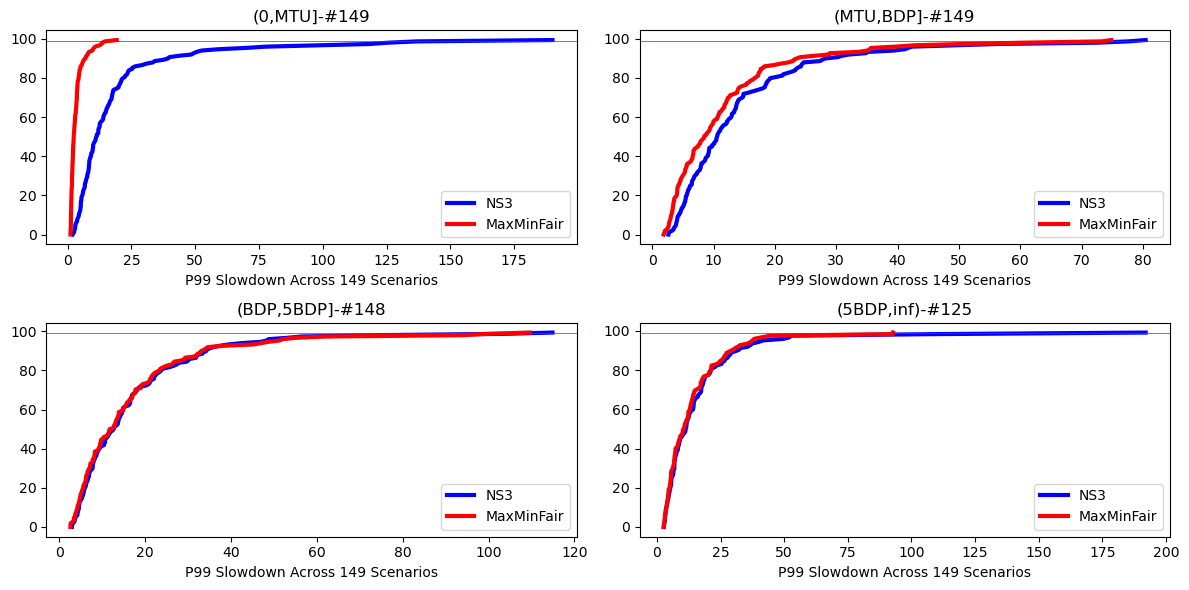

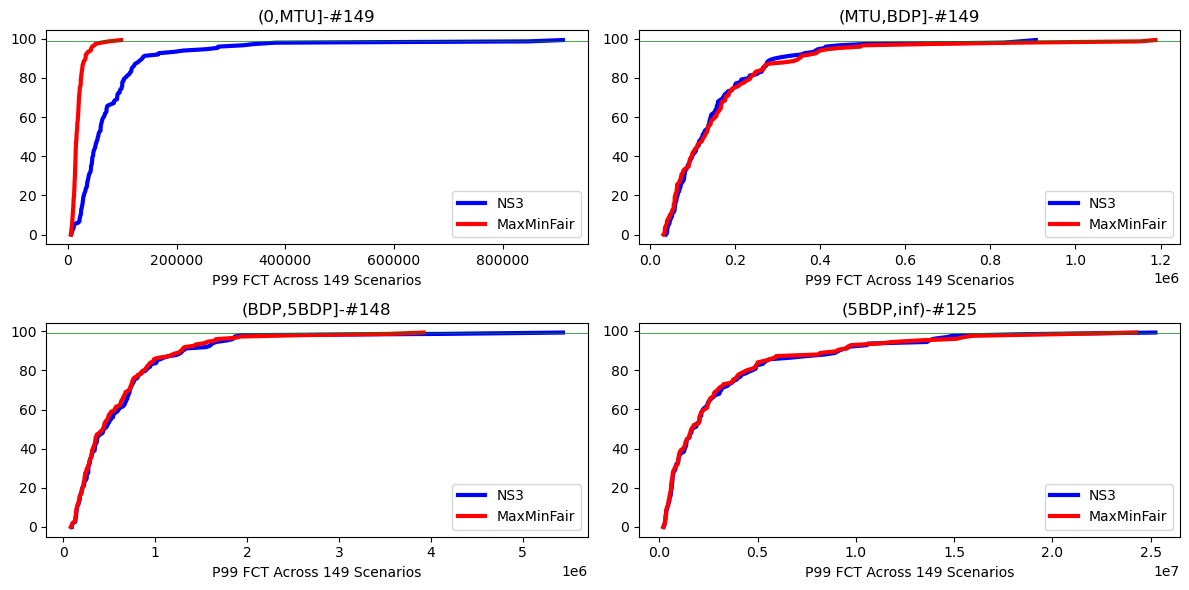

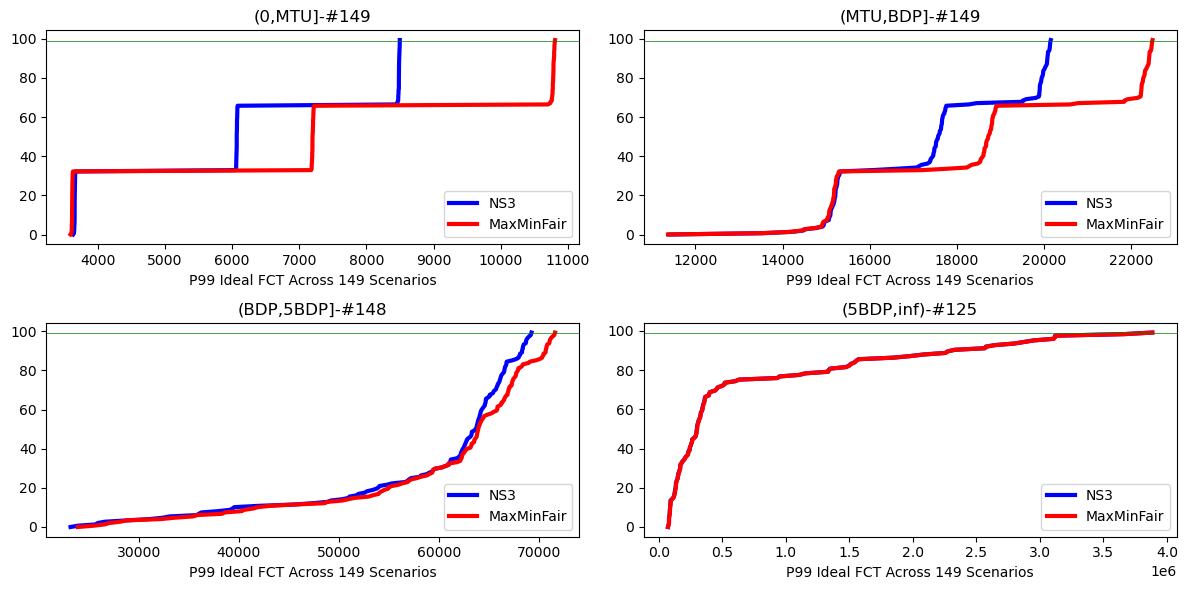

In [18]:
fig_index=0
print("************************************************************************************************************************************************")
print(f'{spec}')
# sceneario_selected=(res_host_list==2).squeeze()
# print(sceneario_selected.shape,res.shape)
# res_selected=res[sceneario_selected]
# res_fct_selected=res_fct[sceneario_selected]
# res_i_fct_selected=res_i_fct[sceneario_selected]
res_selected=res
res_fct_selected=res_fct
res_i_fct_selected=res_i_fct

plt.figure(fig_index,figsize=(12, 6))
for i in range(len(labels)):
    gt = res_selected[:,i,0]
    estimated_flowsim = res_selected[:,i,1]
    
    gt = gt[~np.isnan(gt)]
    estimated_flowsim = estimated_flowsim[~np.isnan(estimated_flowsim)]
    
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}-#{len(gt)}")
    if(len(gt)==0): continue
    # plt.xlim([0, 16])
    plt.plot(np.sort(gt), (np.arange(len(gt))/len(gt)*100), label='NS3', color='blue', linewidth=3)
    plt.plot(np.sort(estimated_flowsim), (np.arange(len(estimated_flowsim))/len(estimated_flowsim)*100), label='MaxMinFair', color='red', linewidth=3)

    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    plt.xlabel(f'P99 Slowdown Across {len(res_fct_selected)} Scenarios')
    plt.legend()
    # plt.ylim([80, 100])
plt.tight_layout()
fig_index+=1
plt.figure(fig_index,figsize=(12, 6))
for i in range(len(labels)):
    gt = res_fct_selected[:,i,0]
    estimated_flowsim = res_fct_selected[:,i,1]
    
    gt = gt[~np.isnan(gt)]
    estimated_flowsim = estimated_flowsim[~np.isnan(estimated_flowsim)]
    
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}-#{len(gt)}")
    if(len(gt)==0): continue
    # plt.xlim([0, 16])
    plt.plot(np.sort(gt), (np.arange(len(gt))/len(gt)*100), label='NS3', color='blue', linewidth=3)
    plt.plot(np.sort(estimated_flowsim), (np.arange(len(estimated_flowsim))/len(estimated_flowsim)*100), label='MaxMinFair', color='red', linewidth=3)

    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    plt.xlabel(f'P99 FCT Across {len(res_fct_selected)} Scenarios')
    plt.legend()
    # plt.ylim([80, 100])
plt.tight_layout()
fig_index+=1
plt.figure(fig_index,figsize=(12, 6))
for i in range(len(labels)):
    gt = res_i_fct_selected[:,i,0]
    estimated_flowsim = res_i_fct_selected[:,i,1]
    
    gt = gt[~np.isnan(gt)]
    estimated_flowsim = estimated_flowsim[~np.isnan(estimated_flowsim)]
    
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}-#{len(gt)}")
    if(len(gt)==0): continue
    # plt.xlim([0, 16])
    plt.plot(np.sort(gt), (np.arange(len(gt))/len(gt)*100), label='NS3', color='blue', linewidth=3)
    plt.plot(np.sort(estimated_flowsim), (np.arange(len(estimated_flowsim))/len(estimated_flowsim)*100), label='MaxMinFair', color='red', linewidth=3)

    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    plt.xlabel(f'P99 Ideal FCT Across {len(res_fct_selected)} Scenarios')
    plt.legend()
    # plt.ylim([80, 100])
plt.tight_layout()

In [9]:
print(res_selected.shape)
q_list=[50]
print(np.nanpercentile(res_selected,q=q_list,axis=0))
print(np.nanpercentile(res_fct_selected,q=q_list,axis=0))
print(np.nanpercentile(res_i_fct_selected,q=q_list,axis=0))

(2, 4, 2)
[[[18.81996287  3.30391343]
  [13.59926425 11.95582773]
  [16.5528339  15.57927104]
  [11.94018328 12.41120438]]]
[[[  91812.565        15357.28664159]
  [ 147887.83        147516.44548828]
  [ 714720.28        610823.96914941]
  [2991491.93       3124009.56899725]]]
[[[  6052.89    5645.176]
  [ 17526.96   17115.568]
  [ 65145.135  64756.916]
  [784897.15  784852.656]]]
